In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.patches import RegularPolygon
import matplotlib
from matplotlib.font_manager import FontProperties

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch
from PIL import Image
import urllib
import os

In [7]:
print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
font_prop = FontProperties(fname="/usr/share/fonts/Nippo-Regular.ttf")
print(font_prop)
matplotlib.rcParams['font.family'] = font_prop.get_name()

['/usr/share/fonts/Nippo-Regular.ttf', '/usr/share/fonts/Nippo-Bold.ttf', '/usr/share/fonts/Nippo-Light.ttf', '/usr/share/fonts/Nippo-Variable.ttf', '/usr/share/fonts/Nippo-Extralight.ttf', '/usr/share/fonts/Nippo-Medium.ttf']
false:style=normal:variant=normal:weight=normal:stretch=normal:file=/usr/share/fonts/Nippo-Regular.ttf:size=10.0


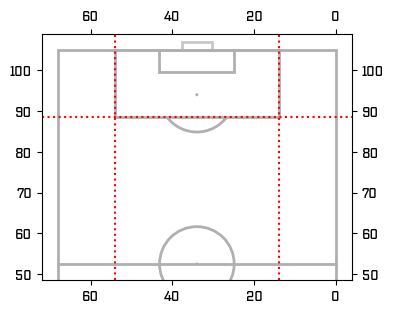

In [8]:
fig = plt.figure(figsize = (4,4), dpi = 100)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='uefa',
    half=True,
    axis=True, 
    label=True, 
    tick=True,
    goal_type='box'
)
pitch.draw(ax = ax)

ax.plot([13.84, 13.84], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=':', color='red')
ax.plot([54.16, 54.16], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=':', color='red')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [88.5,88.5], ls=':', color='red')

In [47]:
data1 = pd.read_csv('/work/assets/understats/player_stats/Bukayo_Saka.csv', index_col=0)
data2 = pd.read_csv('/work/assets/understats/player_stats/Gabriel_Martinelli.csv', index_col=0)
data3 = pd.read_csv('/work/assets/understats/player_stats/Gabriel_Jesus.csv', index_col=0)
data4 = pd.read_csv('/work/assets/understats/player_stats/Martin_Odegaard.csv', index_col=0)
# data4["player"] = "Ansu Fati"
data = pd.concat([data1, data2, data3, data4])
data = data[data['situation'] != 'Penalty'].reset_index(drop=True)
data["team_id"] = 9825
for idx, row in data.iterrows():
    if (row["season"]!=2022) and row["player"] == "Gabriel Jesus":
        data.loc[idx,"team_id"] = 8456
    elif row["season"] == 2019 and row["player"] == "Martin Odegaard":
        data.loc[idx,"team_id"] = 8560
    elif row["season"] == 2020 and row["player"] == "Martin Odegaard":
        data.loc[idx,"team_id"] = 8633
    elif (row["season"] == 2017 or row["season"]==2018 or row["season"]==2019) and row["player"] == "Ferrán Torres":
        data.loc[idx,"team_id"] = 10267
    elif (row["season"] == 2015 or row["season"]==2016) and row["player"] == "Ousmane Dembélé":
        data.loc[idx,"team_id"] = 9851
    elif row["season"]==2017 and row["player"] == "Ousmane Dembélé":
        data.loc[idx,"team_id"] = 9789


In [48]:
def is_inside_box(x,y):
    '''
    Checks if a shot lies within the dimensions of our box.
    '''
    if (x >= 26.16) & (x <= 53.84) & (y >=103.5):
        return True
    else:
        return False

In [49]:
# We invert the data because we're looking at a Vertical Pitch
data['is_in_box'] = [is_inside_box(x,y) for x,y in zip(data['y'], data['x'])]
data["min"] = [minute for minute in range(data.shape[0])]
data_groupped = data.groupby(['player_id', 'player', 'team_id', 'is_in_box', 'season'])["min"].count().reset_index()

In [50]:
data_groupped = data_groupped.pivot(columns='is_in_box', index=['player_id', 'player', 'team_id', 'season'], values='min').reset_index()
data_groupped.columns = ['player_id', 'player', 'team_id', 'season', 'False', 'True']
data_groupped.fillna(0, inplace=True)

In [51]:
data_groupped['total'] = data_groupped['False'] + data_groupped['True']
data_groupped['share'] = data_groupped['True']/data_groupped['total']

In [52]:
data_groupped = (
    data_groupped.sort_values(by=['player','season'], ascending=False)
)
data_groupped = data_groupped[data_groupped["season"]>=2019]

In [53]:
data = data[data['player_id'].isin(data_groupped['player_id'])].reset_index(drop=True)
data = data[data["season"]>=2019]
data

,player,player_id,situation,shot_type,x,y,xG,result,season,match_id,team_id,is_in_box,min
0,Bukayo Saka,7322,OpenPlay,RightFoot,93.119998,33.039999,0.030224,MissedShots,2019,11702,9825,False,0
1,Bukayo Saka,7322,OpenPlay,LeftFoot,102.600000,49.120001,0.100162,SavedShot,2019,11712,9825,False,1
2,Bukayo Saka,7322,OpenPlay,RightFoot,107.880002,38.960001,0.446465,BlockedShot,2019,11712,9825,True,2
3,Bukayo Saka,7322,OpenPlay,RightFoot,103.919998,53.920001,0.068281,BlockedShot,2019,11722,9825,False,3
4,Bukayo Saka,7322,OpenPlay,RightFoot,103.680002,27.200000,0.109344,SavedShot,2019,11844,9825,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,Martin Odegaard,2517,OpenPlay,RightFoot,93.480002,34.479999,0.030989,BlockedShot,2022,18402,9825,False,889
890,Martin Odegaard,2517,OpenPlay,LeftFoot,103.319998,44.400000,0.072782,BlockedShot,2022,18402,9825,False,890
891,Martin Odegaard,2517,OpenPlay,LeftFoot,106.680002,45.279999,0.087024,BlockedShot,2022,18402,9825,True,891
892,Martin Odegaard,2517,OpenPlay,LeftFoot,114.239996,23.360001,0.054818,BlockedShot,2022,18402,9825,False,892


In [54]:
colors = [
    '#7D7D7D',
    '#A8CBAB',
    '#9BCE9F',
    '#88C98E',
    '#75C17B',
    '#68C26F',
    '#57BD5F',
    '#47B550',
    '#32B53D',
    '#049B10'
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

In [55]:
import numpy as np
# function for semicircle
def semicircle(r, h, k):
    x0 = h - r  # determine x start
    x1 = h + r  # determine x finish
    x = np.linspace(x0, x1, 10000)  # many points to solve for y

    # use numpy for array solving of the semicircle equation
    y = k - np.sqrt(r**2 - (x - h)**2)  
    return x, y

In [56]:
def plot_hexbin_shot(ax, playerId, index=None):

    pitch = VerticalPitch(
        pitch_type='statsbomb',
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='#ffffff',
        pad_bottom=-8,
        pad_top=10
    )
    pitch.draw(ax = ax)
    ax.invert_xaxis()
    ax.set_facecolor("#171717")
    
    if index is not None:
        if index == 0 or index == 4 or index == 8 or index == 12:
            season = 2022
            aux_data = data[(data['player_id'] == playerId) & (data['season'] == season)]
        elif index == 1 or index == 5 or index == 9 or index == 13:
            season = 2021
            aux_data = data[(data['player_id'] == playerId) & (data['season'] == season)]
        elif index == 2 or index == 6 or index == 10 or index == 14:
            season = 2020
            aux_data = data[(data['player_id'] == playerId) & (data['season'] == season)]
        elif index == 3 or index == 7 or index == 11 or index == 15:
            season = 2019
            aux_data = data[(data['player_id'] == playerId) & (data['season'] == season)]
        
    else:
        aux_data = data[data['player_id'] == playerId]
    bins = pitch.hexbin(x=aux_data['x'], y=aux_data['y'], ax=ax, cmap='SOC', gridsize=(14,14), zorder=-1, edgecolors='#efe9e6', alpha=0.9, lw=.25)

    x_circle, y_circle = semicircle(120 - aux_data['x'].median(), 40, 120)  # function call
    ax.plot(x_circle, y_circle, ls='--', color='#FFB844', lw=1)

    annot_x = [64 - x*16.00 for x in range(0,4)] 
    annot_texts = ['goals', 'xG', 'shots', 'xG/shot']
    annot_stats = [aux_data[aux_data['result'] == 'Goal'].shape[0], aux_data['xG'].sum(), aux_data.shape[0], aux_data['xG'].sum()/aux_data.shape[0]]
    for x,s,stat in zip(annot_x, annot_texts, annot_stats):
        hex_annotation = RegularPolygon((x, 77), numVertices=6, radius=4.5, edgecolor='#FFB844', fc='#ffffff', hatch='///'*4, lw=1.25)
        ax.add_patch(hex_annotation)
        ax.annotate(
            xy=(x,77),
            text=s,
            xytext=(0,-25),
            textcoords='offset points',
            color="#FFB844",
            size=10,
            ha='center',
            va='center'
        )
        if isinstance(stat, int):
            text_stat = f'{stat:.0f}'
        else:
            text_stat = f'{stat:.2f}'
        text_ = ax.annotate(
            xy=(x,77),
            text=text_stat,
            xytext=(0,0),
            textcoords='offset points',
            size=12,
            color="#023306",
            ha='center',
            va='center',
            weight='bold'
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground='#efe9e6'), path_effects.Normal()]
        )

    # Draw the annotations at the top of the box.
    median_annotation = ax.annotate(
        xy=(40,125),
        xytext=(x_circle[-1], 125),
        text=f"{(((120 - aux_data['x'].median())*18)/16.5)*0.9144:.1f} meter.",
        size=10,
        color='#FFB844',
        ha='right',
        va='center',
        arrowprops=dict(arrowstyle= '<|-, head_width=0.35, head_length=0.65',
            color='#FFB844',
            fc='#efe9e6',
            lw=0.75)
    )

    ax.annotate(
        xy=(40,125),
        xytext=(4,0),
        text=f"median distance",
        textcoords='offset points',
        size=10,
        color='#FFB844',
        ha='left',
        va='center',
        # alpha=0.5
    )

    ax.annotate(
        xy=(40,130),
        text=f"{aux_data['player'].iloc[0].upper()} ver{aux_data['season'].iloc[0]}",
        size=14.5,
        color='#C8FFBC',
        ha='center',
        va='center',
        weight='bold'
    )

    return ax

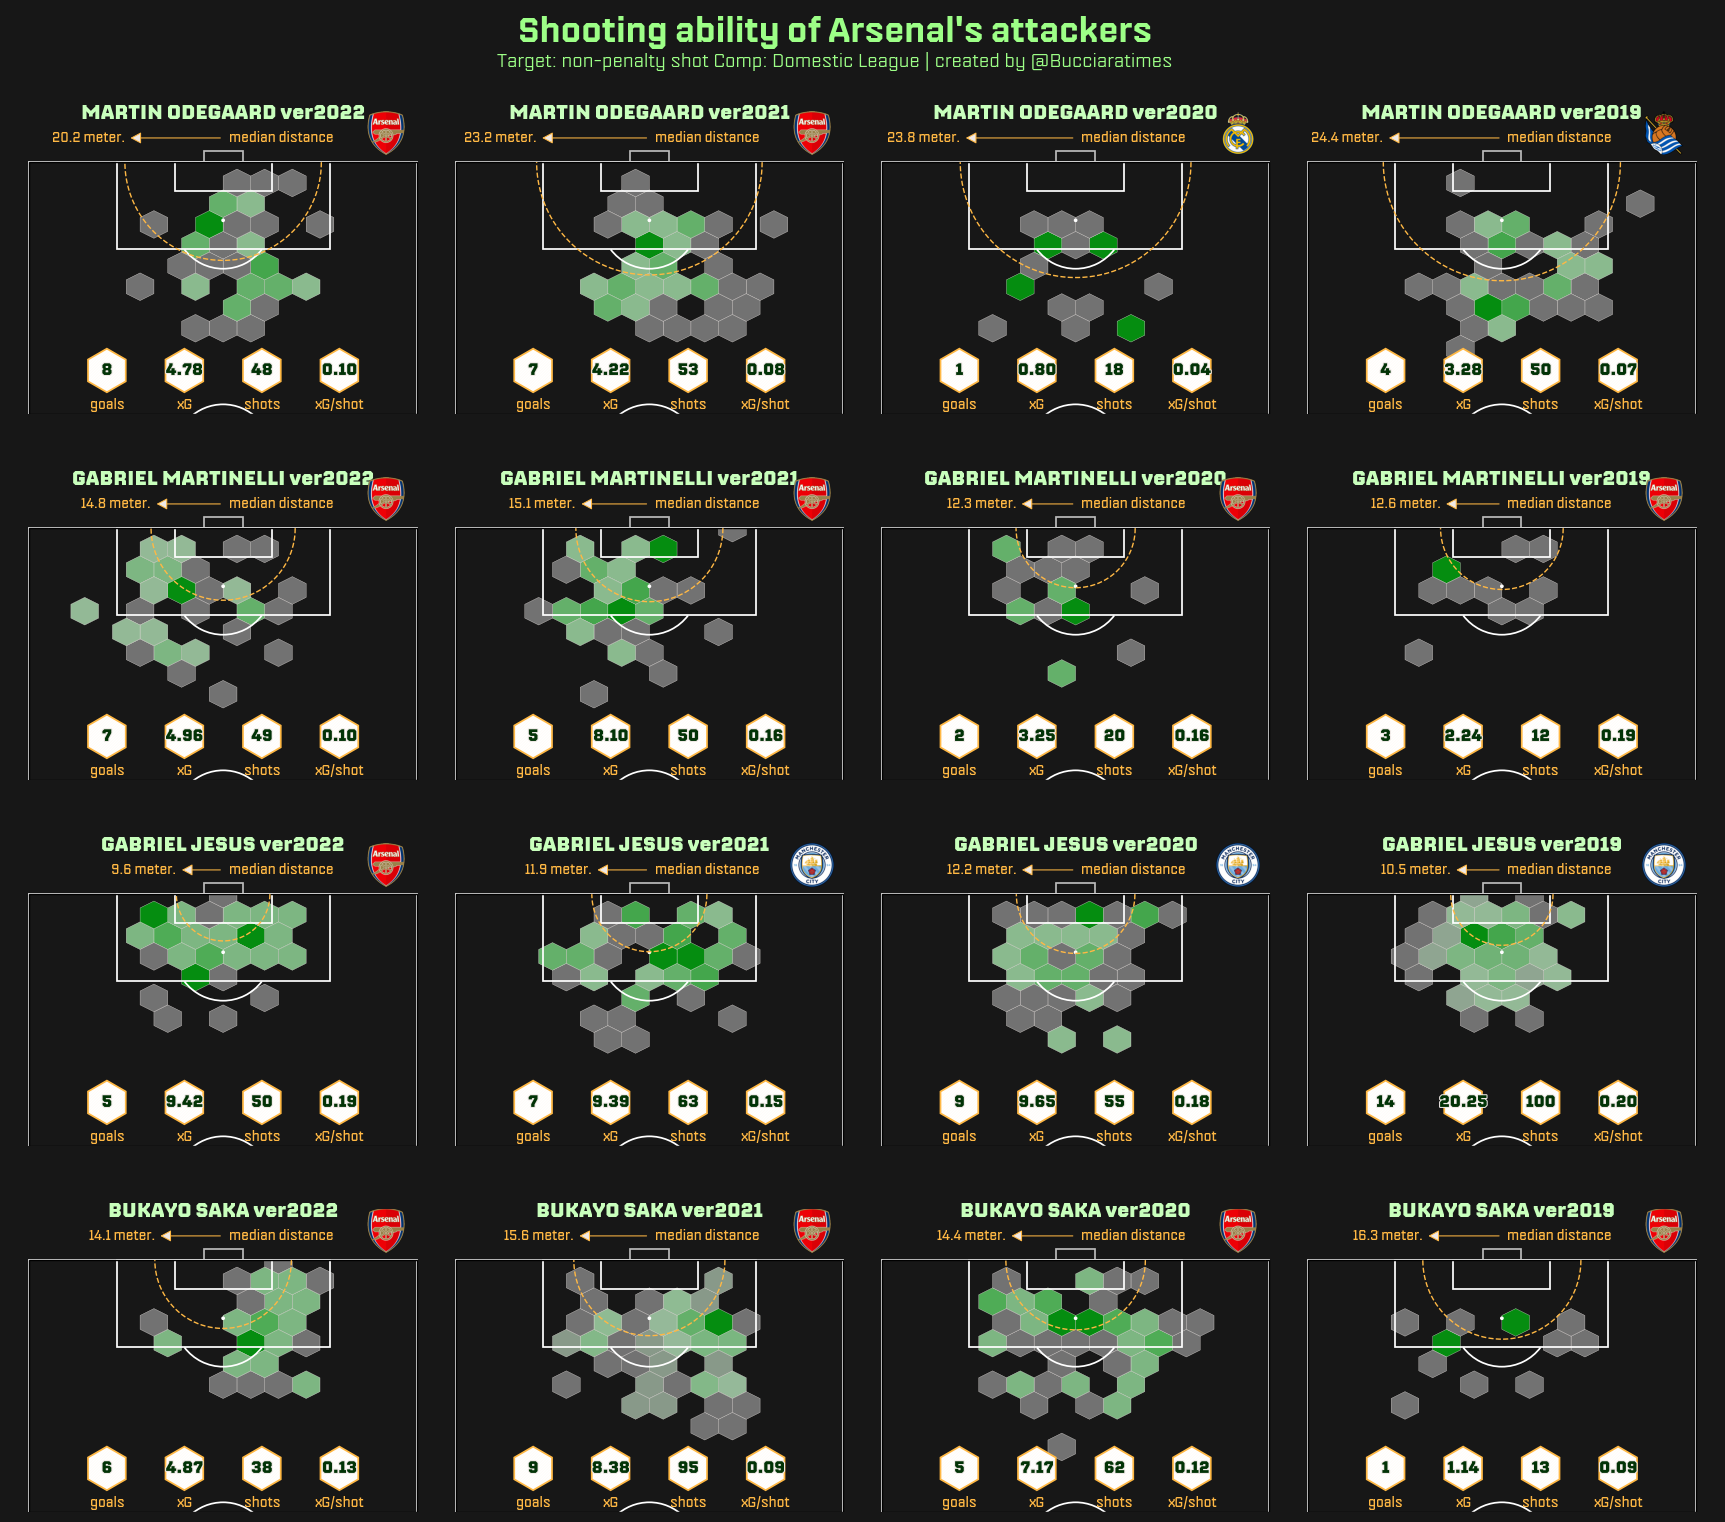

In [57]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(22,22), dpi=100)
fig.set_facecolor("#171717")

axs = np.array(axs)
plt.rcParams['hatch.linewidth'] = .02

for index, ax in enumerate(axs.reshape(-1)):
    plot_hexbin_shot(ax, data_groupped['player_id'].iloc[index], index)


plt.subplots_adjust(wspace=0, hspace=-.35)
# We add the logos once we've reshaped the figure
for index, ax in enumerate(axs.reshape(-1)):
    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((11,111))
    ax_size = 0.02
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{data_groupped["team_id"].iloc[index]:.0f}.png'))
    image_ax.imshow(club_icon)
    image_ax.axis('off')


fig_text(
    x = 0.5, y = .85, 
    s = "Shooting ability of Arsenal's attackers",
    va = "bottom", ha = "center",
    fontsize = 25, color = "#9DFF87", font = "Nippo", weight = "bold"
)
fig_text(
	x = 0.5, y = .84, 
    s = "Target: non-penalty shot Comp: Domestic League | created by @Bucciaratimes",
    # highlight_textprops=[{"weight": "bold", "color": "black"}],
	va = "bottom", ha = "center",
	fontsize = 14, color = "#9DFF87", font = "Nippo"
)
import random
plt.savefig(f'/work/output/{random.uniform(100,1000)}.png', dpi=250, bbox_inches="tight",facecolor="#171717")

In [62]:
data_groupped

,player_id,player,team_id,season,False,True,total,share
25,2275,Ángel Correa,9906,2022,11,15,26,0.576923
24,2275,Ángel Correa,9906,2021,22,28,50,0.560000
23,2275,Ángel Correa,9906,2020,32,20,52,0.384615
22,2275,Ángel Correa,9906,2019,21,22,43,0.511628
8,1804,Álvaro Morata,9906,2022,13,26,39,0.666667
7,1804,Álvaro Morata,9906,2021,27,33,60,0.550000
6,1804,Álvaro Morata,9906,2020,14,41,55,0.745455
5,1804,Álvaro Morata,9906,2019,16,50,66,0.757576
29,7892,João Félix,9906,2022,22,10,32,0.312500
28,7892,João Félix,9906,2021,19,20,39,0.512821
